In [1]:
import os
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as Tr
from torch.optim.lr_scheduler import StepLR
import matplotlib.patches as patches

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class ConvLayer(nn.Module):
    
    def __init__(self, cin, parameters, activation=nn.LeakyReLU(0.1)):
        
        super().__init__()
        
        cout        = parameters['cout']
        kernel_size = parameters['kernel_size']
        padding     = parameters['padding']
        stride      = parameters['stride'] 
        
        conv = nn.Conv2d(in_channels=cin, 
                         out_channels=cout, 
                         kernel_size=kernel_size, 
                         padding=padding,
                         stride=stride,
                         bias=False)
        bn =  nn.BatchNorm2d(cout)
        self.layer = nn.Sequential(*[conv, bn, activation])
    
    def forward(self, x):
        
        return self.layer(x)
    
class FCLayers(nn.Module):
    
    def __init__(self, cin, fc_architecture, activation=nn.LeakyReLU(0.1)):
        
        super().__init__()
        
        S = fc_architecture['S']
        B = fc_architecture['B']
        C = fc_architecture['C']
        c_hidden = fc_architecture['c_hidden']
        
        layer_list = []
        layer_list.append(nn.Flatten())
        layer_list.append(nn.Linear(cin*S*S, c_hidden))
        layer_list.append(activation)
        layer_list.append(nn.Linear(c_hidden, (C+5*B)*S*S))
        self.layers = nn.Sequential(*layer_list)
        self.S = S
        self.C = C
        self.B = B
        
    def forward(self, x):
        
        return self.layers(x).reshape(-1, self.S, self.S, self.C+5*self.B)

class YOLO1(nn.Module):
    
    def __init__(self, cnn_architecture, fc_architecture, cin=3, activation=nn.LeakyReLU(0.1)):
        
        super().__init__()
        
        layer_list = []
        c_input = cin
        
        for element in cnn_architecture:
            if element['type']=='cnn_block':
                for n in range(element['repeat']):
                    for parameters in element['layers']:
                        layer_list.append(ConvLayer(c_input, parameters, activation))
                        c_input = parameters['cout']
            if element['type']=='maxpool':
                pool = nn.MaxPool2d(kernel_size=element['parameters']['kernel_size'], stride=element['parameters']['stride'])
                layer_list.append(pool)
                    
        self.layers = nn.Sequential(*layer_list)
        
        self.fc_layers = FCLayers(c_input, fc_architecture, activation=activation)
    
    def forward(self, x):
        
        out = self.layers(x)
        out = self.fc_layers(out)

        return out

In [3]:
class YoloLoss(nn.Module):

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        
        class_probs = predictions[:,:,:,0:self.C]
        Probs = predictions[:,:,:,self.C::5]
        allbox_x = predictions[:,:,:,self.C+1::5]
        allbox_y = predictions[:,:,:,self.C+2::5]
        allbox_w = predictions[:,:,:,self.C+3::5]
        allbox_h = predictions[:,:,:,self.C+4::5]
        allbox_w_sqrt = torch.sqrt(torch.abs(allbox_w))*torch.sign(allbox_w)
        allbox_h_sqrt = torch.sqrt(torch.abs(allbox_h))*torch.sign(allbox_h)

        targetclass = target[:,:,:,0:self.C]
        exists_box = target[:,:,:,[self.C]]
        targetbox_x = target[:,:,:,[self.C+1]]
        targetbox_y = target[:,:,:,[self.C+2]]
        targetbox_w = target[:,:,:,[self.C+3]]
        targetbox_h = target[:,:,:,[self.C+4]]
        targetbox_w_sqrt = torch.sqrt(targetbox_w)
        targetbox_h_sqrt = torch.sqrt(targetbox_h)

        ### IOU Score ###
        allbox_x1 = allbox_x - 0.5*allbox_w
        allbox_x2 = allbox_x + 0.5*allbox_w
        allbox_y1 = allbox_y - 0.5*allbox_h
        allbox_y2 = allbox_y + 0.5*allbox_h

        targetbox_x1 = targetbox_x - 0.5*targetbox_w
        targetbox_x2 = targetbox_x + 0.5*targetbox_w
        targetbox_y1 = targetbox_y - 0.5*targetbox_h
        targetbox_y2 = targetbox_y + 0.5*targetbox_h

        intersetbox_x1= torch.maximum(allbox_x1, targetbox_x1)
        intersetbox_x2= torch.minimum(allbox_x2, targetbox_x2)
        intersetbox_y1= torch.maximum(allbox_y1, targetbox_y1)
        intersetbox_y2= torch.minimum(allbox_y2, targetbox_y2)

        intersection_area = (intersetbox_x2-intersetbox_x1).clamp(0)*(intersetbox_y2 - intersetbox_y1).clamp(0)
        allbox_area = torch.abs(allbox_w*allbox_h)
        targetbox_area = torch.abs(targetbox_w*targetbox_h)
        all_iou = intersection_area/(allbox_area+targetbox_area-intersection_area+ 1e-6)
        maxiou_idx = all_iou.argmax(dim=-1)
        maxiou_onehot = nn.functional.one_hot(maxiou_idx) # selects the box with higher iou

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        box_loss = self.mse(maxiou_onehot*exists_box*targetbox_x, maxiou_onehot*exists_box*allbox_x)
        box_loss += self.mse(maxiou_onehot*exists_box*targetbox_y, maxiou_onehot*exists_box*allbox_y)
        box_loss += self.mse(maxiou_onehot*exists_box*targetbox_w_sqrt, maxiou_onehot*exists_box*allbox_w_sqrt)
        box_loss += self.mse(maxiou_onehot*exists_box*targetbox_h_sqrt, maxiou_onehot*exists_box*allbox_h_sqrt)

        # ======================= #
        #   FOR OBJECT LOSS       #
        # ======================= #

        object_loss = self.mse(maxiou_onehot*exists_box, maxiou_onehot*exists_box*Probs)

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(exists_box*targetclass, exists_box*class_probs)

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.mse((1-exists_box)*exists_box, (1-exists_box)*Probs[:,:,:,[0]])
        for j in range(1,self.B):
            no_object_loss += self.mse((1-exists_box)*exists_box, (1-exists_box)*Probs[:,:,:,[j]])

        # ======================= #
        #   Total LOSS            #
        # ======================= #   

        loss = (
                self.lambda_coord * box_loss  # first two rows in paper
                + object_loss  # third row in paper
                + self.lambda_noobj * no_object_loss  # forth row
                + class_loss  # fifth row
                )
        
        return loss


In [4]:
def intersection_over_union(boxes_preds, boxes_labels):
    """
    Calculates intersection over union
    """

    box1_x1 = boxes_preds[0] - boxes_preds[2] / 2
    box1_y1 = boxes_preds[1] - boxes_preds[3] / 2
    box1_x2 = boxes_preds[0] + boxes_preds[2] / 2
    box1_y2 = boxes_preds[1] + boxes_preds[3] / 2
    box2_x1 = boxes_labels[0] - boxes_labels[2] / 2
    box2_y1 = boxes_labels[1] - boxes_labels[3] / 2
    box2_x2 = boxes_labels[0] + boxes_labels[2] / 2
    box2_y2 = boxes_labels[1] + boxes_labels[3] / 2

    x1 = max(box1_x1, box2_x1)
    y1 = max(box1_y1, box2_y1)
    x2 = min(box1_x2, box2_x2)
    y2 = min(box1_y2, box2_y2)

    intersection = max((x2 - x1),0) * max((y2 - y1),0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [5]:
def convert_cellboxes(predictions,C=20):
    """
    Converts bounding boxes output from Yolo into entire image ratios
    rather than relative to cell ratios. 
    """
    batch_size, S, S, L =  predictions.shape
    B = int((L-C)/5)
    x_offset = torch.arange(S).repeat((S,1))
    y_offset = torch.arange(S).reshape(-1,1).repeat((1,S))

    predictions_converted = predictions.detach()

    for n in range(B):
        predictions_converted[:,:,:,C+n*5+1] = (predictions_converted[:,:,:,C+n*5+1]+x_offset)/S
        predictions_converted[:,:,:,C+n*5+2] = (predictions_converted[:,:,:,C+n*5+2]+y_offset)/S
        predictions_converted[:,:,:,C+n*5+3] = predictions_converted[:,:,:,C+n*5+3]/S
        predictions_converted[:,:,:,C+n*5+4] = predictions_converted[:,:,:,C+n*5+4]/S
        
    return predictions_converted

In [6]:
def non_max_suppression(predictions, iou_threshold, threshold, C=20):
    """
    works with a single prediction
    """
    predictions_converted = convert_cellboxes(predictions,C)
    batch_size, S, S, L =  predictions.shape 
    B = int((L-C)/5)

    all_boxes = []

    for n in range(B):
        boxes = predictions_converted[:,:,:,list(range(C))+list(range(C+n*5, C+n*5+5))]
        boxes[:,:,:,0:C] = boxes[:,:,:,[C]]*boxes[:,:,:,0:C]
        boxes = boxes.reshape(-1,C+5).tolist()
        all_boxes = all_boxes+boxes

    boxes_after_nms = {}     

    for class_index in range(C):
        filtered_boxes = list(filter(lambda x: x[class_index]>threshold, all_boxes))
        filtered_boxes = sorted(filtered_boxes, key=lambda x: x[class_index], reverse=True)
        box_coords = list(map(lambda x: x[C+1:C+5], filtered_boxes))
        boxes_after_nms_perclass = []
        while box_coords:
            chosen_box = box_coords.pop(0)
            boxes_after_nms_perclass.append(chosen_box)
            for idx, box in enumerate(box_coords):
                iou = intersection_over_union(chosen_box, box)
                if iou > iou_threshold:
                    del box_coords[idx]
        boxes_after_nms[class_index] = boxes_after_nms_perclass
        
    return boxes_after_nms

In [7]:
class VOCDataset(Dataset):
    
    def __init__(self, path, file, S=7, C=20, imagesize=448):
        
        self.data = pd.read_csv(os.path.join(path, file), header=None).values
        self.sample_path = os.path.join(os.path.join(path, 'images'))
        self.label_path = os.path.join(os.path.join(path, 'labels'))
        labelname_file = open(os.path.join(path,'labelnames.txt'), "r") 
        names = labelname_file.readlines() 
        labelname_file.close()
        self.labelnames = list(map(lambda x:x.split('\n')[0], names))
        self.S = S
        self.C = C
        self.imagesize = imagesize
    
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self,index):
        
        img = Image.open(os.path.join(self.sample_path, self.data[index,0]))
        img = img.resize((self.imagesize,self.imagesize))
        sample = np.asanyarray(img)
        sample = sample/255
        sample = torch.tensor(np.transpose(sample, (2,0,1)), dtype=torch.float)
        label_raw = np.loadtxt(os.path.join(self.label_path, self.data[index,1]))
        if len(label_raw.shape)==1:
            label_raw = label_raw.reshape(1,5)
        label = torch.zeros((self.S, self.S, self.C + 5))

        for n in range(len(label_raw)):
            c = int(label_raw[n,0])
            loc = (self.S*label_raw[n,1:3]).astype(int)
            box_center = self.S*label_raw[n,1:3] - loc
            box_size = self.S*label_raw[n,3:5]
            box = torch.tensor(np.concatenate((box_center, box_size)), dtype=torch.float)
            label[loc[1], loc[0], c] = 1
            label[loc[1], loc[0], self.C] = 1
            label[loc[1], loc[0], self.C+1:] = box

        
        return sample, label

In [8]:
def plot_boxes(boxes, width, height, ax, color="r"):
    
    for box in boxes:
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor=color,
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
    return ax

In [9]:
def plot_prediction(dataset, model, idx, iou_threshold=0.5, threshold=0.5):
    
    labelnames = np.array(dataset.labelnames)
    C = len(labelnames)
    x = dataset[idx][0]
    y = dataset[idx][1]
    x = x.unsqueeze(0)
    y = y.unsqueeze(0)
    y_pred = model(x)
    image = np.transpose(x.numpy()[0,:,:,:], (1,2,0))
    width = image.shape[0]
    height = image.shape[1]
    true_boxes = non_max_suppression(y, iou_threshold, threshold, C)
    true_classes = []
    pred_boxes = non_max_suppression(y_pred, iou_threshold, threshold, C)
    pred_classes = []

    fig, ax = plt.subplots()
    ax.imshow(image)
    for n in range(C):
        if true_boxes[n]:
            true_classes.append(n)
            ax=plot_boxes(true_boxes[n], width, height, ax, color='r') 
        if pred_boxes[n]:
            pred_classes.append(n)
            ax=plot_boxes(pred_boxes[n], width, height, ax, color='g') 
    print('true classes: '+', '.join(list(labelnames[true_classes])))
    print('predicted classes: '+', '.join(list(labelnames[pred_classes])))

In [10]:
path_data = './data/PascalVOC_YOLO/'

batch_size = 16

train_dataset = VOCDataset(path_data, 'train.csv', imagesize=448)

test_dataset = VOCDataset(path_data, 'test.csv', imagesize=448)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

-[source #1](https://arxiv.org/abs/1506.02640)

-[source #2](https://www.youtube.com/watch?v=n9_XyCGr-MI&list=PLy5rjn5-uSPAKe2PfszYRqNY7JJC45P1d&index=7&t=1920s)

In [11]:
cnn_architecture = []

element_1 = {'type': 'cnn_block',
             'layers':[{'cout':64,
                        'kernel_size':7,
                        'padding': 3,
                        'stride':2}],
            'repeat': 1}

cnn_architecture.append(element_1)

element_2 = {'type': 'maxpool',
             'parameters':{'kernel_size':2,
                           'stride': 2}} 

cnn_architecture.append(element_2)

element_3 = {'type': 'cnn_block',
             'layers':[{'cout':192,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':1}],
            'repeat': 1}

cnn_architecture.append(element_3)

element_4 = {'type': 'maxpool',
             'parameters':{'kernel_size':2,
                           'stride': 2}} 

cnn_architecture.append(element_4)

element_5 = {'type': 'cnn_block',
             'layers':[{'cout':128,
                        'kernel_size':1,
                        'padding': 0,
                        'stride':1},
                      {'cout':256,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':1},
                      {'cout':256,
                        'kernel_size':1,
                        'padding': 0,
                        'stride':1},
                      {'cout':512,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':1}],
            'repeat': 1}

cnn_architecture.append(element_5)

element_6 = {'type': 'maxpool',
             'parameters':{'kernel_size':2,
                           'stride': 2}} 

cnn_architecture.append(element_6)

element_7 = {'type': 'cnn_block',
             'layers':[{'cout':256,
                        'kernel_size':1,
                        'padding': 0,
                        'stride':1},
                      {'cout':512,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':1}],
            'repeat': 4}

cnn_architecture.append(element_7)

element_8 = {'type': 'cnn_block',
             'layers':[{'cout':512,
                        'kernel_size':1,
                        'padding': 0,
                        'stride':1},
                      {'cout':1024,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':1}],
            'repeat': 1}

cnn_architecture.append(element_8)

element_9 = {'type': 'maxpool',
             'parameters':{'kernel_size':2,
                           'stride': 2}} 

cnn_architecture.append(element_9)

element_10 = {'type': 'cnn_block',
             'layers':[{'cout':512,
                        'kernel_size':1,
                        'padding': 0,
                        'stride':1},
                      {'cout':1024,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':1}],
            'repeat': 2}

cnn_architecture.append(element_10)

element_11 = {'type': 'cnn_block',
             'layers':[{'cout':1024,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':1},
                      {'cout':1024,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':2},
                      {'cout':1024,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':1},
                      {'cout':1024,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':1}],
            'repeat': 1}

cnn_architecture.append(element_11)

fc_architecture ={'S':7, 'B':2, 'C':20, 'c_hidden': 496}

In [12]:
model = YOLO1(cnn_architecture, fc_architecture)

In [13]:
for (x,y) in train_loader:
    break

In [14]:
x.shape

torch.Size([16, 3, 448, 448])

In [15]:
y.shape

torch.Size([16, 7, 7, 25])

In [16]:
y_pred = model(x)

In [17]:
y_pred.shape

torch.Size([16, 7, 7, 30])

In [18]:
target = y
predictions = y_pred

In [19]:
lossfn = YoloLoss()
lossfn(predictions, target)

tensor(1226.3551, grad_fn=<AddBackward0>)

In [20]:
train_dataset.data

array([['000005.jpg', '000005.txt'],
       ['000007.jpg', '000007.txt'],
       ['000009.jpg', '000009.txt'],
       ...,
       ['2011_003259.jpg', '2011_003259.txt'],
       ['2011_003274.jpg', '2011_003274.txt'],
       ['2011_003276.jpg', '2011_003276.txt']], dtype=object)

true classes: bottle, person
predicted classes: 


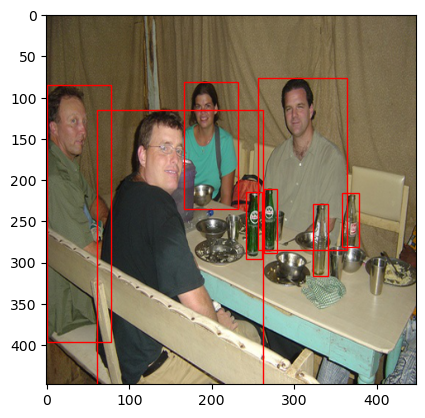

In [23]:
dataset = train_dataset
idx = 12
plot_prediction(dataset, model, idx)